# Exploratory Data Analysis of supermarket customers behavior

## Questions
- Calculate the total number of customers in each section
- Calculate the total number of customers in each section over time
- Display the number of customers at checkout over time
- Calculate the time each customer spent in the market
- Calculate the total number of customers in the supermarket over time.
- Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).
- Estimate the total revenue for a customer (section, revenue per minute)

## SETUP

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 17 08:49:50 2020

Script for iterating over data csv files in a data directory, and saving them in a dictionary of pandas dataframes

@author: hanbo
"""

import os
from pathlib import Path
import pandas as pd

####################################

data_dir= '../data'
files = os.listdir(data_dir)
my_sep = ';'
my_dfs = {}

for file in files:
    
   full_path = Path(data_dir) / Path(file)
   #print(full_path)
   #add each df to a dictionary
   df_name = file.split('.')[0]
   #print(df_name)
   df = pd.read_csv(full_path, sep = my_sep)
   my_dfs[df_name] = df

In [4]:
monday = pd.read_csv("../data/monday.csv", sep=";")
tuesday = pd.read_csv("../data/tuesday.csv", sep=";")
wednesday = pd.read_csv("../data/wednesday.csv", sep=";")
thursday = pd.read_csv("../data/thursday.csv", sep=";")
friday = pd.read_csv("../data/friday.csv", sep=";")

monday["weekday"] = "monday"
tuesday["weekday"] = "tuesday"
wednesday["weekday"] = "wednesday"
thursday["weekday"] = "thursday"
friday["weekday"] = "friday"

# Create a dataframe with all days
df = monday.append(tuesday, ignore_index=True)
df = df.append(wednesday, ignore_index=True)
df = df.append(thursday, ignore_index=True)
df = df.append(friday, ignore_index=True)

# Extract the hour from the timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["time"] = df["timestamp"].dt.time

In [343]:
data = pd.read_csv("./data/monday.csv", header=0, sep=";", parse_dates=True)
data.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [347]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.dtypes

timestamp      datetime64[ns]
customer_no            object
location               object
dtype: object

In [346]:
# Encode the customer nr and day into one variable

data["customer_no"]=data["customer_no"].apply(lambda x: str(x)+'_monday')
data["customer_no"]

0          1_monday
1          2_monday
2          3_monday
3          4_monday
4          5_monday
           ...     
4889    1447_monday
4890    1430_monday
4891    1433_monday
4892    1437_monday
4893    1439_monday
Name: customer_no, Length: 4894, dtype: object

## DATA ANALYSIS - one day 

In [345]:
#missing customers from checkout
checkout=set(data[data["location"]=="checkout"]["customer_no"].unique())
all_c=set(data["customer_no"].unique())
diff=all_c.difference(checkout)
for cust in diff:
    data=data.append({"timestamp":"2019-09-02 22:00:00","customer_no":cust,
    "location":"checkout"}, ignore_index=True)


data[data["timestamp"]=="2019-09-02 22:00:00"]

,timestamp,customer_no,location
4884,2019-09-02 22:00:00,1440,checkout
4885,2019-09-02 22:00:00,1441,checkout
4886,2019-09-02 22:00:00,1443,checkout
4887,2019-09-02 22:00:00,1445,checkout
4888,2019-09-02 22:00:00,1446,checkout
4889,2019-09-02 22:00:00,1447,checkout
4890,2019-09-02 22:00:00,1430,checkout
4891,2019-09-02 22:00:00,1433,checkout
4892,2019-09-02 22:00:00,1437,checkout
4893,2019-09-02 22:00:00,1439,checkout


Text(0.5, 1.0, 'Customer distribution by location')

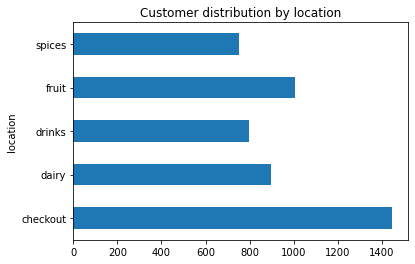

In [334]:
data.groupby(["location"])['customer_no'].count().plot.barh()
plt.title("Customer distribution by location")

Text(0.5, 1.0, 'Percentage of customers per section')

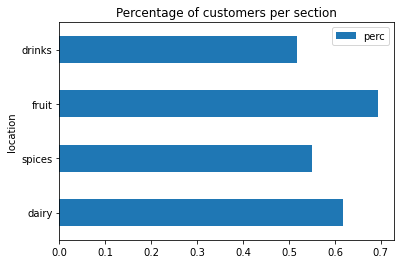

In [335]:
cust_per_aile=data[data['location']!="checkout"].groupby(["location"])['customer_no'].count()
cust_total=data[data['location']=="checkout"].groupby(["location"])['customer_no'].count()
perc_cust=pd.to_numeric(cust_per_aile.values)/pd.to_numeric(cust_total.values)
p=pd.concat([pd.DataFrame(perc_cust),pd.DataFrame(pd.unique(data['location'][data['location']!="checkout"]))], axis=1)
p.columns=["perc",'location']
p.set_index("location", inplace=True)
p.plot.barh()
plt.title("Percentage of customers per section")

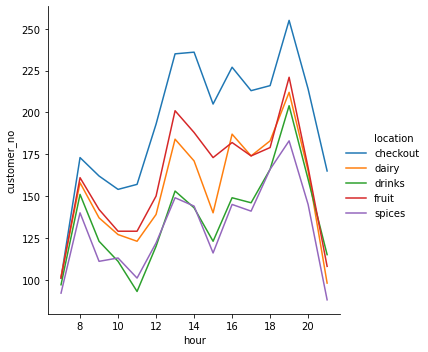

In [6]:
# Nr of customers in each section over time

total_customers_time = pd.DataFrame(df.groupby(["location","hour"])["customer_no"].nunique())
total_customers_time.reset_index(inplace=True)
sns.relplot(x="hour", y="customer_no", hue="location", kind="line", data=total_customers_time)

Text(0.5, 1.0, 'Customer behavior at diffrent hours of the day')

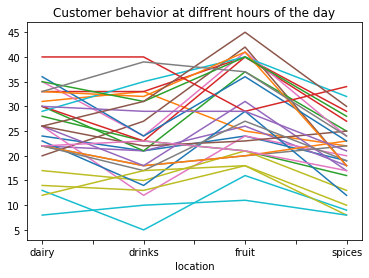

In [366]:
data[data['location']!="checkout"].groupby("location").resample("30T").nunique()['customer_no'].unstack().plot(legend=False)
plt.title("Customer behavior at diffrent hours of the day")

Text(0.5, 1.0, 'Amount of people at the checkout in an interval of 15 mins')

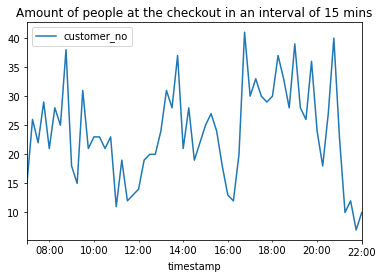

In [354]:
data.reset_index(inplace=True)
data[data['location']=="checkout"].groupby("location").resample("15T").nunique()['customer_no'].reset_index().set_index("timestamp").plot()
plt.title("Amount of people at the checkout in an interval of 15 mins")

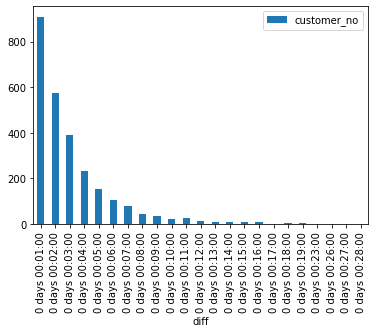

In [368]:
data['diff'] = data.sort_values(['customer_no','timestamp']).groupby('customer_no')['timestamp'].diff()
data[data["diff"].notnull()][["customer_no","diff"]].groupby("diff").nunique()["customer_no"].reset_index().set_index("diff").plot.bar()
plt.tite("How much time do customers spend in the shop?")


In [357]:
# Amount spent by each customer
data[data["diff"].notnull()][["customer_no","diff"]]

,customer_no,diff
8,1_monday,00:02:00
9,5_monday,00:01:00
10,6_monday,00:01:00
11,7_monday,00:01:00
12,2_monday,00:03:00
...,...,...
4889,1447_monday,00:10:00
4890,1430_monday,00:11:00
4891,1433_monday,00:11:00
4892,1437_monday,00:13:00


Text(0.5, 1.0, 'Total customer numbers inside the supermarket over time')

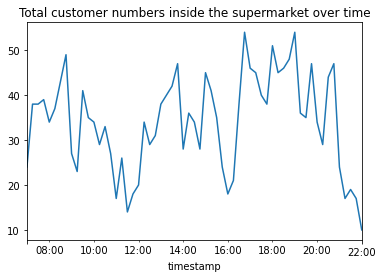

In [359]:
data.resample("15T").nunique()["customer_no"].plot()
plt.title("Total customer numbers inside the supermarket over time")

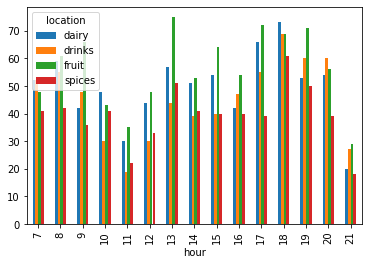

In [363]:
data["hour"]=data.index.hour
data[data["location"] !="checkout"].groupby(["hour","location"]).nunique()["customer_no"].unstack().plot.bar()

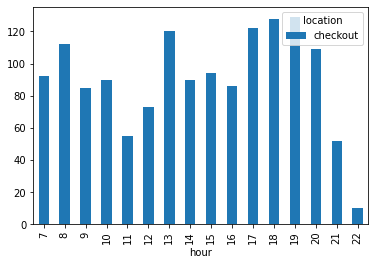

In [364]:
data["hour"]=data.index.hour
data[data["location"] =="checkout"].groupby(["hour","location"]).nunique()["customer_no"].unstack().plot.bar()

## DATA ANALYSIS - all days

In [ ]:
def missing_checkout(data):
    checkout=set(data[data["location"]=="checkout"]["customer_no"].unique())
    all_c=set(data["customer_no"].unique())
    diff=all_c.difference(checkout)
    for cust in diff:
        data=data.append({"timestamp":"2019-09-02 22:00:00","customer_no":cust,
        "location":"checkout"}, ignore_index=True)

    return data

def cust_no_name(data, weekday):
    data["customer_no"]=data["customer_no"].apply(lambda x: str(x)+"_"+ weekday)
    return data

In [389]:
monday=pd.read_csv("./data/monday.csv", header=0, sep=";", parse_dates=True)
missing_checkout(monday)
monday["weekday"]="monday"
cust_no_name(monday,"monday")

tuesday=pd.read_csv("./data/tuesday.csv", header=0, sep=";", parse_dates=True)
missing_checkout(tuesday)
tuesday["weekday"]="tuesday"
cust_no_name(tuesday,"tuesday")

wednesday=pd.read_csv("./data/wednesday.csv", header=0, sep=";", parse_dates=True)
missing_checkout(wednesday)
wednesday["weekday"]="wednesday"
cust_no_name(wednesday,"wednesday")

thursday=pd.read_csv("./data/thursday.csv", header=0, sep=";", parse_dates=True)
missing_checkout(thursday)
thursday["weekday"]="thursday"
cust_no_name(thursday,"thursday")

friday=pd.read_csv("./data/thursday.csv", header=0, sep=";", parse_dates=True)
missing_checkout(friday)
friday["weekday"]="friday"
cust_no_name(friday,"friday")

data=pd.concat([monday,tuesday,wednesday,thursday, friday])
data["timestamp"]=pd.to_datetime(data["timestamp"])
data.set_index("timestamp",inplace=True)
data

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1_monday,dairy,monday
1,2019-09-02 07:03:00,2_monday,dairy,monday
2,2019-09-02 07:04:00,3_monday,dairy,monday
3,2019-09-02 07:04:00,4_monday,dairy,monday
4,2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...,...
5099,2019-09-05 21:48:00,1533_friday,dairy,friday
5100,2019-09-05 21:48:00,1534_friday,fruit,friday
5101,2019-09-05 21:48:00,1535_friday,spices,friday
5102,2019-09-05 21:49:00,1534_friday,checkout,friday


## Total number of unique customers in a week

In [5]:
df["customer_no"].nunique()
#1535 unique customers = max. nr of customers in a day

1535

In [6]:
daily_customers = pd.DataFrame(df.groupby("weekday")["customer_no"].nunique())
daily_customers.reset_index(inplace=True)
px.bar(daily_customers, x='weekday', y='customer_no')

## Total number of customers in each section 

In [9]:
total_customers_section = pd.DataFrame(df.groupby("location")["customer_no"].nunique())
total_customers_section.reset_index(inplace=True)
px.bar(total_customers_section, x='location', y='customer_no')

,location,customer_no
0,checkout,1532
1,dairy,1483
2,drinks,1434
3,fruit,1494
4,spices,1393


## Total number of customers in each section over time

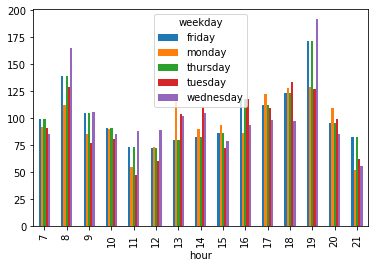

In [392]:
# By day and hour

data["hour"]=data.index.hour
data[data["location"] =="checkout"].groupby(["hour","weekday"]).nunique()["customer_no"].unstack().plot.bar()

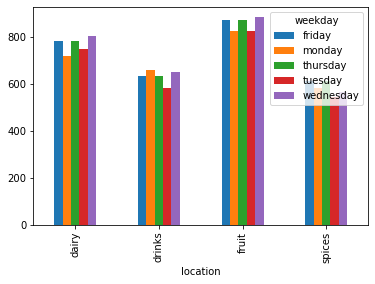

In [441]:
# By day an location 

data[data["location"] !="checkout"].groupby(["location","weekday"]).nunique()["customer_no"].groupby(["location","weekday"]).mean().unstack().plot.bar()

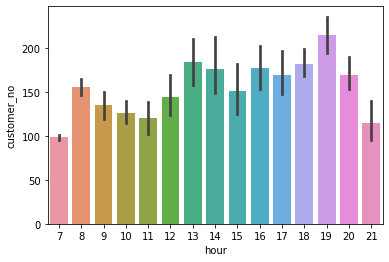

In [13]:
sns.barplot(data=total_customers_time, y='customer_no', x='hour', orient='v')

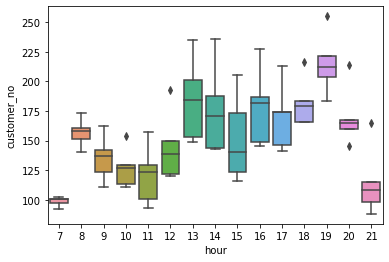

In [14]:
sns.boxplot(data=total_customers_time, y='customer_no', x='hour', orient='v')

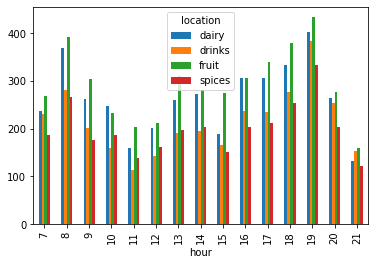

In [437]:
data["hour"]=data.index.hour
data[data["location"] !="checkout"].groupby(["hour","location"]).nunique()["customer_no"].groupby(["hour","location"]).mean().unstack().plot.bar()

In [15]:
px.bar(total_customers_time, x='hour', y='customer_no', color="location")

In [16]:
px.line(total_customers_time, x="hour", y="customer_no", color="location", hover_name="location",line_shape="spline")